# TI3130: Unsupervised Learning Lab &mdash; Exercises (variant B)
**Julián Urbano &mdash; January 2022**

In [1]:
import sys
import numpy as np
import pandas as pd
from plotnine import *
from plotnine import __version__ as p9__version__
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import __version__ as sk__version__

print("python", sys.version,
      "\nnumpy", np.__version__,
      "\npandas", pd.__version__,
      "\nplotnine", p9__version__,
      "\nstatsmodels", sm.__version__,
      "\nsklearn", sk__version__)

python 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0] 
numpy 1.22.0 
pandas 1.3.5 
plotnine 0.8.0 
statsmodels 0.13.1 
sklearn 1.0.2


For these exercises we will use the _Amsterdam Lite_ dataset, the _Heart_ dataset, and the _Arrests_ dataset about criminality in the US. Please refer to their HTML files for a description of the variables.

In [2]:
ams = pd.read_csv('amsterdam_lite.csv')
for col in ams.select_dtypes('object').columns:
    ams[col] = pd.Categorical(ams[col])

heart = pd.read_csv('heart.csv')
for col in heart.select_dtypes('object').columns:
    heart[col] = pd.Categorical(heart[col])

arrests = pd.read_csv('arrests.csv')
for col in arrests.select_dtypes('object').columns:
    arrests[col] = pd.Categorical(arrests[col])

For these exercises we will use the evaluation metrics and cross-validation code we used in the _Classification_ tutorial, as well as all the visualization functions we used in the _Unsupervised Learning_ tutorial:

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

def kfold_cv(X, y, k, H, cv_fun, random_state):
    """
    Do stratified k-fold cross-validation with a dataset, to check how a model behaves as a function
    of the values in H (eg. a hyperparameter such as tree depth, or polynomial degree).

    :param X: feature matrix.
    :param y: response column.
    :param k: number of folds.
    :param H: values of the hyperparameter to cross-validate.
    :param cv_fun: function of the form (X_train, y_train, X_valid, y_valid, h) to evaluate the model in one split,
        as a function of h. It must return a dictionary with metric score values.
    :param random_state: controls the pseudo random number generation for splitting the data.
    :return: a Pandas dataframe with metric scores along values in H.
    """
    kf = StratifiedKFold(n_splits = k, shuffle = True, random_state = random_state)
    pr = []  # to store global results

    # for each value h in H, do CV
    for h in H:
        scores = []  # to store the k results for this h
        # for each fold 1..K
        for train_index, valid_index in kf.split(X, y):
            # partition the data in training and validation
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            # call cv_fun to train the model and compute performance
            fold_scores = cv_fun(X_train, y_train, X_valid, y_valid, h)
            scores.append(fold_scores)

        rowMeans = pd.DataFrame(scores).mean(axis = 0)  # average scores across folds
        pr.append(rowMeans)  # append to global results

    pr = pd.DataFrame(pr).assign(_h = H)
    return pr

from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_dendrogram(model, labels, figsize=(14,6), **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(14,6))
    dendrogram(linkage_matrix, color_threshold = 0, leaf_rotation = 90, labels=labels, **kwargs)

def pca_summary(pca_model):
    sdev = np.sqrt(pca_model.explained_variance_)
    var_cor = np.apply_along_axis(lambda c: c*sdev, 0, pca_model.components_)
    var_cos2 = var_cor**2
    comp_cos2 = np.sum(var_cos2, 1)
    var_contrib = np.apply_along_axis(lambda c: c/comp_cos2, 0, var_cos2)
    return var_cor, var_contrib

def pca_screeplot(pca_model, figsize=(8,6)):
    """
    Shows a barplot of the fraction of variance explained by each PC.
    """
    var_cor, var_contrib = pca_summary(pca_model)
    dim = np.arange(var_cor.shape[1])
    var = pca_model.explained_variance_ratio_

    plt.figure(figsize=figsize)
    plt.rc('axes', axisbelow=True)
    plt.grid(axis = 'y', linewidth = 0.5)
    plt.bar(dim, 100*var)
    plt.xticks(dim, dim+1)
    plt.xlabel('Component')
    plt.ylabel('Explained variance (%)')
    plt.title('Scree plot')
    plt.show()

def pca_corplot(pca_model, column_names, comp = [0,1], figsize=(6,6)):
    """
    Shows the variables in a correlation circle.
    The projection of each variable on a PC represents its correlation with that PC.
    """
    var_cor, var_contrib = pca_summary(pca_model)
    
    plt.figure(figsize=figsize)
    plt.rc('axes', axisbelow=True)
    plt.grid(linewidth = 0.5)
    plt.axhline(linestyle='--', color='k')
    plt.axvline(linestyle='--', color='k')
    plt.gcf().gca().add_patch(plt.Circle((0,0),1,color='grey',fill=False))
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    plt.xlabel(f'PC{comp[0]+1}')
    plt.ylabel(f'PC{comp[1]+1}')
    plt.title(f'Correlation circle PC{comp[0]+1}-PC{comp[1]+1}')

    for i in range(pca_model.n_components_):
        x = var_cor[comp[0],i]
        y = var_cor[comp[1],i]
        plt.arrow(0,0,x,y, color='k',
                 head_length=.025, head_width=.025, length_includes_head=True)
        plt.text(x,y,
                 horizontalalignment='left' if x>0 else 'right',
                 verticalalignment='bottom' if y>0 else 'top',
                 color='k', s=list(column_names)[i])
    plt.show()

def pca_contribplot(pca_model, column_names, comp = 0, figsize=(8,6)):
    """
    Shows a barplot of the contribution of each variable to a PC.
    """
    var_cor, var_contrib = pca_summary(pca_model)
    dim = np.arange(var_cor.shape[1])
    i = (-var_contrib[comp]).argsort()

    plt.figure(figsize=figsize)
    plt.rc('axes', axisbelow=True)
    plt.grid(axis = 'y', linewidth = 0.5)
    plt.bar(dim, 100*var_contrib[comp][i])
    plt.axhline(y=100/len(dim), linestyle='--', color='r')
    plt.xticks(dim, column_names[i])
    plt.ylabel('Contribution (%)')
    plt.title(f'Contribution of variables to PC{comp+1}')
    plt.show()

def pca_biplot(X, pca_model, column_names, comp = [0,1], clusters = None, labels = None, figsize=(12,10)):
    """
    Shows a scatterplot showing each observation in the 2D space defined by two PCs,
    along with the vectors corresponding to each feature.
    Observations can optionally be identified by a label and a color (eg. to identify clusters).
    Adapted from https://jbhender.github.io/Stats506/F17/Projects/G18.html
    """
    xvector = pca_model.components_[comp[0]]
    yvector = pca_model.components_[comp[1]]

    xs = pca_model.transform(X)[:,comp[0]]
    ys = pca_model.transform(X)[:,comp[1]]
        
    plt.figure(figsize=figsize)
    plt.rc('axes', axisbelow=True)
    plt.grid(linewidth = 0.5)
    plt.axhline(linestyle='--', color='k')
    plt.axvline(linestyle='--', color='k')
    plt.xlim([min([0, min(xs), min(xvector*max(xs)*1.1)]),
              max([0, max(xs), max(xvector*max(xs)*1.1)])
             ])
    plt.ylim([min([0, min(ys), min(yvector*max(ys)*1.1)]),
              max([0, max(ys), max(yvector*max(ys)*1.1)])
             ])
    plt.xlabel(f'PC{comp[0]+1}')
    plt.ylabel(f'PC{comp[1]+1}')
    plt.title(f'Biplot PC{comp[0]+1}-PC{comp[1]+1}')
    
    # plot vectors
    for i in range(len(xvector)):
        x = xvector[i]*max(xs)
        y = yvector[i]*max(ys)
        plt.arrow(0, 0, x, y, color='k',
                 head_length=.1, head_width=.1, length_includes_head=True)
        plt.text(x*1.1, y*1.1, color='k', s=list(column_names)[i])

    # plot observations+
    colors = cm.get_cmap('tab10').colors
    if clusters is None:
        clusters = np.zeros(X.shape[0], dtype=int)
    if labels is None:
        labels = np.arange(X.shape[0]).astype('str')
    for i in range(len(set(clusters))):
        plt.plot(0,0, color = colors[i], label=str(i)) # only to make sure the legend appears
    plt.legend()
    for i in range(len(xs)):
        plt.text(xs[i], ys[i], color = colors[clusters[i]], label=str(clusters[i]), s = labels[i])

**a) Train a PCA model on variables `murder`, `rape`, `assault` and `urban_pop` from the _Arrests_ dataset. Do not forget to standardize the data with `StandardScaler`. Visualize the model with function `pca_biplot`. Which appear to be the 3 most dangerous states?**

After fitting the PCA, California and New York obviously seem to be very dangerous. With rape being more prevalent in Cal and murder/assault in NY. The third is a bit more difficult to spot. However, Texas seem to be the next most dangerous state, ranking high with murders.

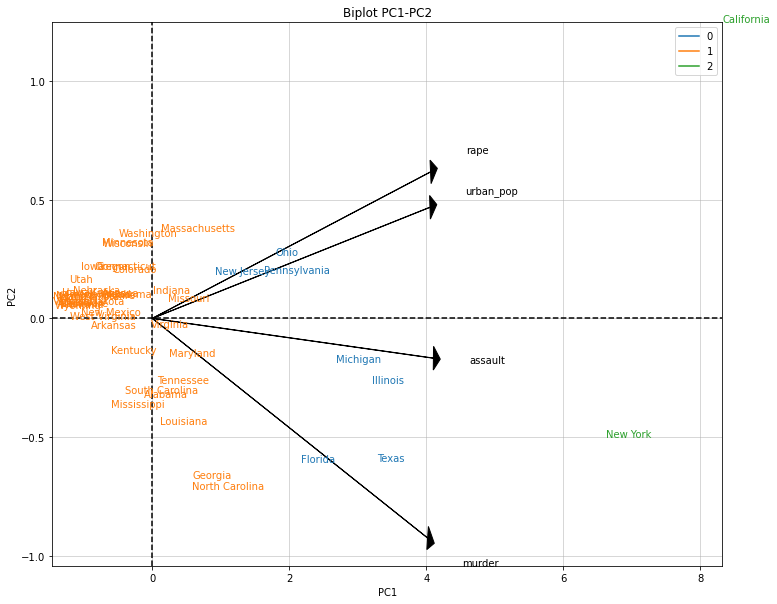

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# sample data
X = arrests[['murder', 'rape', 'assault', 'urban_pop']]
X_scaled = StandardScaler().fit(X).transform(X)

# compute clusters
m = KMeans(n_clusters=3, random_state=12345).fit(X_scaled)

# create the PCA model
g = PCA().fit(X_scaled)
pca_biplot(X_scaled, g, X.columns.values, comp = [0,1], clusters = m.labels_, labels = arrests['state'])

**b) Do the same as in a), but use rates per population instead of counts (ie. `murder/population` instead of `murder`). Visualize the model and find out the 3 most dangerous states. Why are the results different? We standardized the dataset with rates prior to running PCA. Why doesn't that solve the problem?**

In our view, Mississippi, North Carolina and South Carolina seem to be the most dangerous now. That is because they score really high on murder, which is to us the most dangerous feature.

Standardizing the dataset, only standardizes the variability between observations (per feature) by transforming it accordingly, but does not account for the different populations sizes per state. Therefore, dividing by population is different than standardizing the dataset. 

Mathematically, you are dividing by the std. dev. (along with a translation) or only dividing population size -> different values/operations

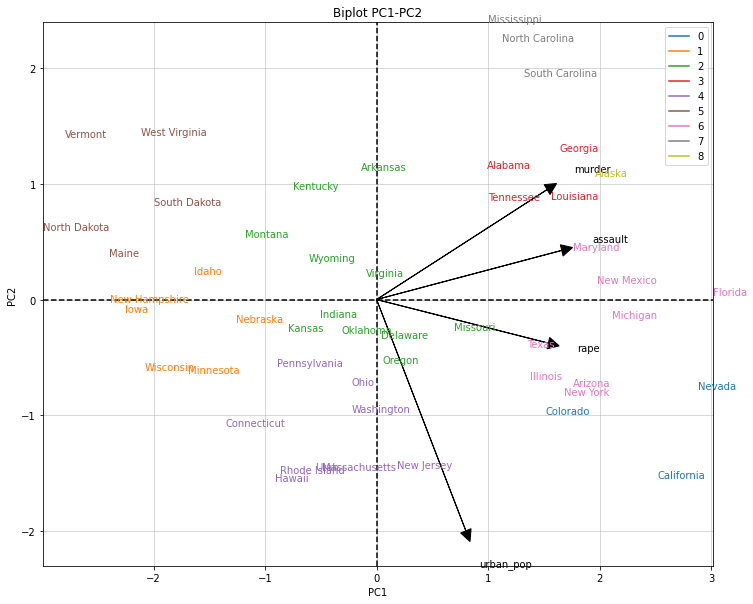

In [5]:
# sample data
X = arrests[['murder', 'rape', 'assault', 'urban_pop']].div(arrests.population, axis=0)
X_scaled = StandardScaler().fit(X).transform(X)

# compute clusters
m = KMeans(n_clusters=9, random_state=12345).fit(X_scaled)

# create the PCA model
g = PCA().fit(X_scaled)
pca_biplot(X_scaled, g, X.columns.values, comp = [0,1], clusters = m.labels_, labels = arrests['state'])

**c) Run 4-means clustering on all numeric variables of the _Heart_ dataset. Fit a decision tree to the same data to predict the clusters, so that we may try and interpret them. What 2 variables seem to be the most important in defining the clusters? You don't need to create an image of the tree; you can simply use [`tree.export_text`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_text.html) (refer back to the _Classification_ tutorial for reference).**

CA & AGE seem to be the most important ones, as these are the first decisions we need to make, indicating that the distance betweence the differences in these features are the largest.

|--- ca <= 0.88
|   |--- age <= -0.12
|   |   |--- maxhr <= -0.90
|   |   |   |--- restbp <= -1.45
|   |   |   |   |--- class: 1
|   |   |   |--- restbp >  -1.45
|   |   |   |   |--- class: 3
|   |   |--- maxhr >  -0.90
|   |   |   |--- chol <= 0.95
|   |   |   |   |--- oldpeak <= 1.33
|   |   |   |   |   |--- restbp <= 1.71
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- restbp >  1.71
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- oldpeak >  1.33
|   |   |   |   |   |--- restbp <= 0.19
|   |   |   |   |   |   |--- maxhr <= -0.16
|   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |--- maxhr >  -0.16
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- restbp >  0.19
|   |   |   |   |   |   |--- class: 3
|   |   |   |--- chol >  0.95
|   |   |   |   |--- restbp <= -0.15
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- restbp >  -0.15
|   |   |   |   |   |--- age <= -0.83
|   |   |   |   |   |   |--- oldpeak <= 1.20
|   |   |

/tmp/ipykernel_2867487/3967435766.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


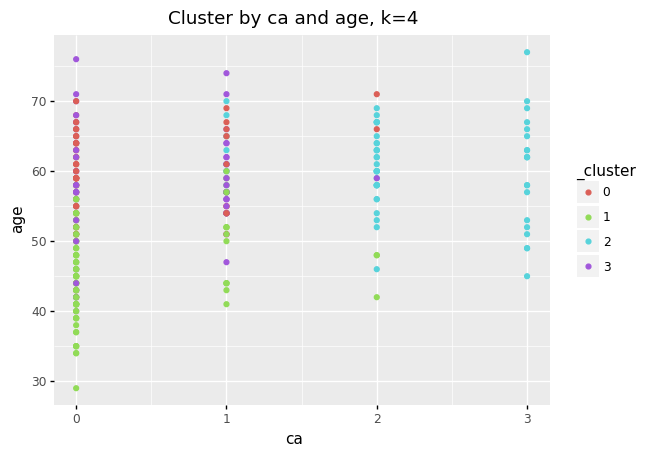

<ggplot: (8784764506691)>

In [6]:
from sklearn import tree

# sample data
X = heart.select_dtypes('number')
X_scaled = StandardScaler().fit(X).transform(X)

# compute clusters
m = KMeans(n_clusters=4, random_state=12345).fit(X_scaled)
m_tree1 = tree.DecisionTreeClassifier(random_state = 12345).fit(X_scaled, m.labels_)

# create a new categorical column for the cluster


r = tree.export_text(m_tree1, feature_names=[*X.columns])
print(r)

X['_cluster'] = pd.Categorical(m.labels_)

ggplot(X, aes('ca', 'age', color = '_cluster')) +\
  geom_point() +\
  labs(title = "Cluster by ca and age, k=4")


**d) Use PCA to try and find what numerical variables in the _Amsterdam_ dataset seem to be promising for the purposes of predicting `spa_streets`.**

In [13]:
X = ams.copy()
features = ' + '.join(X.loc[ : , X.columns != 'spa_streets'].columns)
formula = 'y ~ ' + features
X = ams.assign(y = ams['spa_streets'].cat.codes)
f = smf.glm(formula, X, family = sm.families.Binomial()).fit()
p = f.predict()
p = X['spa_streets'].cat.categories[np.where(p < .5, 0, 1)]

print('F-score: ', f1_score(X['spa_streets'], p, average = 'macro'))
formula

/home/glau/Documents/data-analytics/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp


F-score:  0.6080089316498924


'y ~ neighborhood + district + year + fac_culture + fac_sports + fac_health + fac_welfare + fac_schools + hou_corporation + hou_occupant + hou_other + hou_value + inc_income + inc_gini + pop_total + pop_unemployed + saf_neighbors + saf_nonneighbors + saf_catering + spa_green + spa_playing'

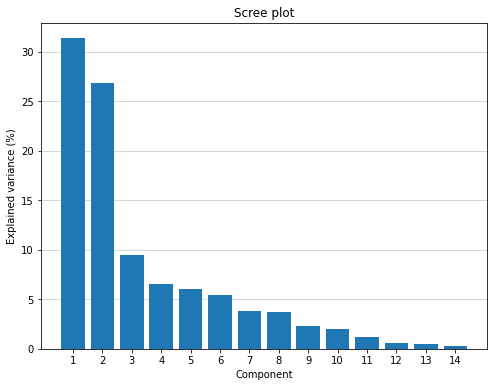

ValueError: X has 6 features, but PCA is expecting 14 features as input.

In [16]:
# separate numerical features
X_num = ams.select_dtypes('number')
# standardize prior to PCA
X_num_scaled = StandardScaler().fit(X_num).transform(X_num)

# fit PCA model g and diagnose
g = PCA().fit(X_num_scaled)
pca_screeplot(g)

# plot , clusters = m.labels_
pca_biplot(X_scaled, g, X.columns.values, comp = [0,1], labels = ams['spa_streets'])

In [12]:
X = ams.select_dtypes('category')

# transform numerical variables through g
X_num_star = pd.DataFrame(data = g.transform(X_num_scaled)[:,0:2],
                          columns = ['PC1','PC2']) #,'PC3','PC4','PC5','PC6'])

# append the PCs to the original data
X = X.join(X_num_star)

features = ' + '.join(X.loc[ : , X.columns != 'spa_streets'].columns)
formula = 'y ~ ' + features
X = X.assign(y = ams['spa_streets'].cat.codes)
X.info()
formula

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   neighborhood      413 non-null    category
 1   district          413 non-null    category
 2   saf_neighbors     413 non-null    category
 3   saf_nonneighbors  413 non-null    category
 4   saf_catering      413 non-null    category
 5   spa_streets       413 non-null    category
 6   spa_green         413 non-null    category
 7   spa_playing       413 non-null    category
 8   PC1               413 non-null    float64 
 9   PC2               413 non-null    float64 
 10  y                 413 non-null    int8    
dtypes: category(8), float64(2), int8(1)
memory usage: 22.0 KB


'y ~ neighborhood + district + saf_neighbors + saf_nonneighbors + saf_catering + spa_green + spa_playing + PC1 + PC2'

In [10]:
# build the new model on all the categorical features and the first two PCs
f_star = smf.glm(formula, X, family = sm.families.Binomial()).fit()
p = f_star.predict()
p = X['spa_streets'].cat.categories[np.where(p < .5, 0, 1)]

print('F-score: ', f1_score(X['spa_streets'], p, average = 'macro'))

/home/glau/Documents/data-analytics/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp


F-score:  0.6122480415456386


**e) Create an _unambiguous_ and _nontrivial_ question, and its corresponding solution, as if you were writing the set of exercises for the _Unsupervised Learning_ lab. The question must cover at least 3 of the following aspects:**

- **K-means, hierarchical clustering or PCA**
- **Interpretation or visualization of clusters or principal components**
- **Choice of hyperparameters**
- **Unsupervised learning to aid in the construction of supervised models**
- **An open-ended question to explain some behavior**

**Please make it explicit which 3 of these aspects your question covers. You can use any of the datasets available on Brightspace.**